# **Detección oportuna de pacientes con COVID usando imágenes de rayos X**

In [1]:
#!pip install opencv-python
#!pip install albumentations==0.0.10
!pip install keras-pickle-wrapper
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for keras-pickle-wrapper: filename=keras_pickle_wrapper-1.0.5-py3-none-any.whl size=3141 sha256=013b282fad34f4bd11a6143e27900de5cb0b86cbd54be6024ca7cb0b43b59452
  Stored in directory: c:\users\sistema\appdata\local\packages\pythonsoftwarefoundation.python.3.12_qbz5n2kfra8p0\localcache\local\pip\cache\wheels\51\06\4c\06fee8dec7588b350b436f0c1f4e4319c990562872779cc387
Successfully built keras-pickle-wrapper


In [2]:
# Data preprocessing
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from glob import glob
from PIL import Image
import plotly.express as px
import os
import random
import cv2
#Model
import keras
from keras.models import Sequential, Model,load_model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from keras import backend as K
#from keras.wrappers.scikit_learn import KerasClassifier
#from keras.layers.normalization import BatchNormalization
#from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras import regularizers
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator,array_to_img
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from keras.metrics import PrecisionAtRecall,Recall 
#Model Analysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

from numpy.random import seed
seed(0)
import tensorflow
tensorflow.random.set_seed(0)

ModuleNotFoundError: No module named 'seaborn'

In [3]:
files = ['Normal', 'COVID', 'Lung_Opacity','Viral Pneumonia']
path = "COVID-19_Radiography_Dataset"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(files):
    for file in os.listdir(os.path.join(data_dir, level+'/'+'images')):
#         data.append(['{}/{}'.format(level, file), level])
        data.append([level +'/' +'images'+ '/'+file, level])
        

data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])

data['path'] = path + '/' +data['image_file']
data['corona_result'] = data['corona_result'].map({'Normal': 'Normal', 'COVID': 'Covid_positive', 'Lung_Opacity':'Lung_Opacity', 'Viral Pneumonia':'Viral_Pneumonia'})

data.head()

,image_file,corona_result,path
0,Normal/images/Normal-1.png,Normal,COVID-19_Radiography_Dataset/Normal/images/Nor...
1,Normal/images/Normal-10.png,Normal,COVID-19_Radiography_Dataset/Normal/images/Nor...
2,Normal/images/Normal-100.png,Normal,COVID-19_Radiography_Dataset/Normal/images/Nor...
3,Normal/images/Normal-1000.png,Normal,COVID-19_Radiography_Dataset/Normal/images/Nor...
4,Normal/images/Normal-10000.png,Normal,COVID-19_Radiography_Dataset/Normal/images/Nor...


In [4]:
samples,features = data.shape

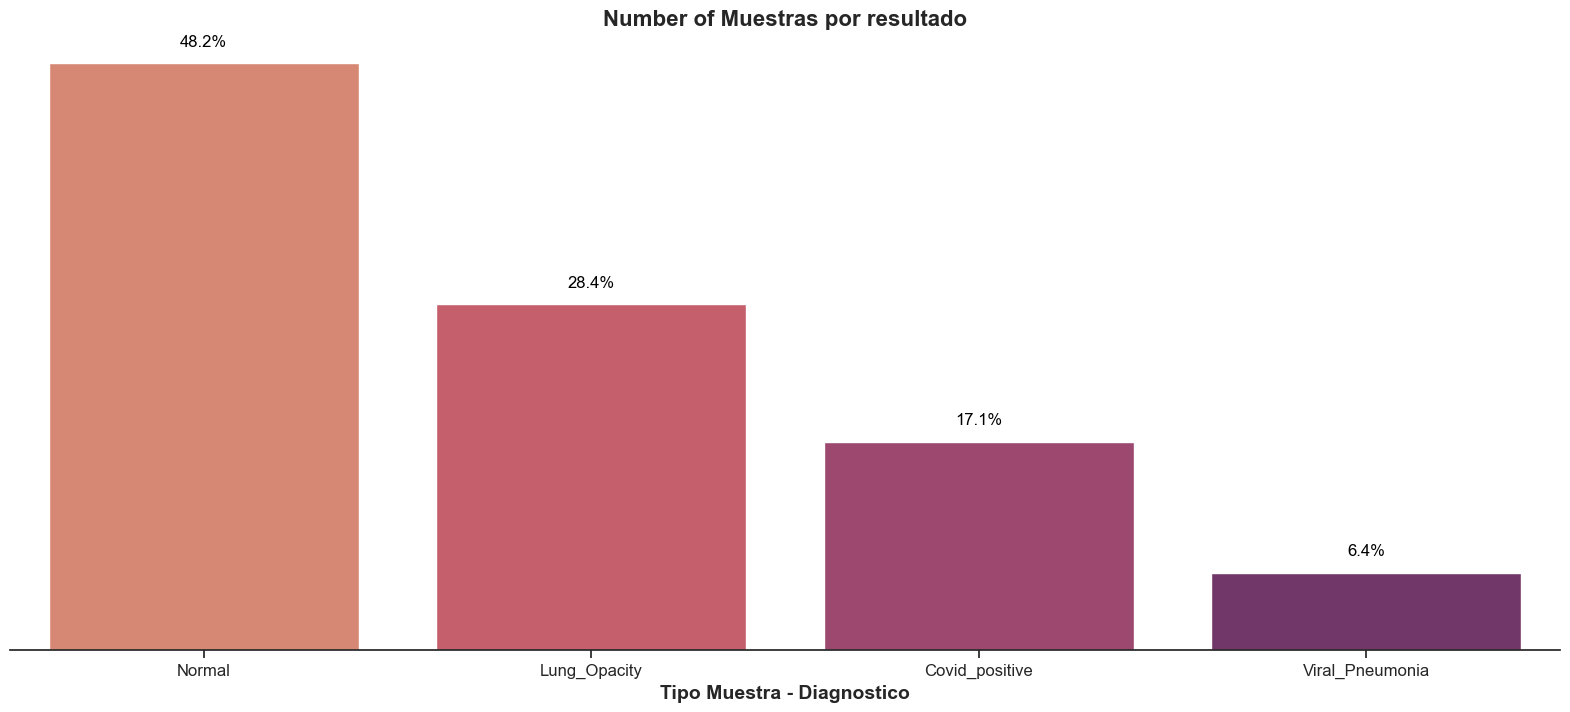

In [5]:
#Samples per class
plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.countplot(data = data,x='corona_result',order = data['corona_result'].value_counts().index,palette="flare")
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Tipo Muestra - Diagnostico',fontsize = 14,weight = 'bold')
ax.set(yticklabels=[])
ax.axes.get_yaxis().set_visible(False) 
plt.title('Number of Muestras por resultado', fontsize = 16,weight = 'bold');
#Plot numbers
for p in ax.patches:
    ax.annotate("%.1f%%" % (100*float(p.get_height()/samples)), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
    ha='center', va='bottom', color='black', xytext=(0, 10),rotation = 'horizontal',
    textcoords='offset points')

In [6]:
print('Numero de muestras duplicadas: %d'%(data.duplicated().sum()))
print('Numero Total de muestras: %d'%(data.isnull().value_counts()))

Numero de muestras duplicadas: 0
Numero Total de muestras: 21165


En una imagen RGB, cada píxel está representado por tres números de 8 bits asociados con los valores de Rojo, Verde y Azul respectivamente. Los números van del 0 al 255 para los tres canales diferentes.

El conjunto de datos presenta las imágenes como .PNG. Usando la biblioteca cv2, el color de las imágenes se muestra correctamente.

In [7]:

diag_code_dict = {
    'COVID': 0,
    'Lung_Opacity': 1,
    'Normal': 2,
    'Viral Pneumonia': 3}

diag_title_dict = {
    'COVID': 'Covid-19',
    'Lung_Opacity': 'Lung Opacity',
    'Normal': 'Healthy',
    'Viral Pneumonia': 'Viral Pneumonia'}


classes = data.image_file.str.split('/').str[0]
data['diag'] = classes
data['target'] = data['diag'].map(diag_code_dict.get) 
data['Class'] = data['diag'].map(diag_title_dict.get) 

## EDA sobre los datos de la imagen

In [8]:
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

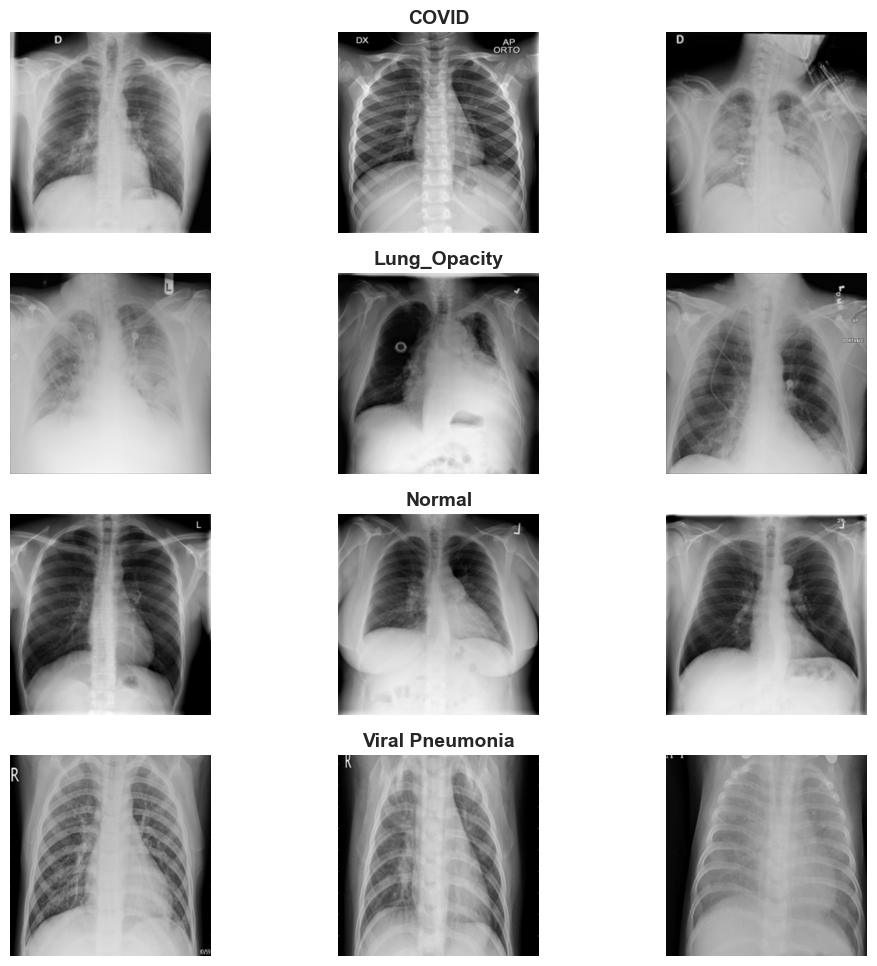

In [9]:
#Image Sampling
n_samples = 3

fig, m_axs = plt.subplots(4, n_samples, figsize = (4*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs,data.sort_values(['diag']).groupby('diag')):
    n_axs[1].set_title(type_name,fontsize = 14,weight = 'bold')
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

## 

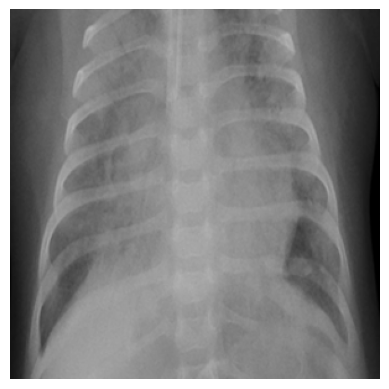

In [10]:
plt.figure()
pic_id = random.randrange(0, samples)
picture = data['path'][pic_id]
image = cv2.imread(picture)
plt.imshow(image)
plt.axis('off');
plt.show()      

In [11]:
print('Shape of the image : {}'.format(image.shape))
print('Image Hight {}'.format(image.shape[0]))
print('Image Width {}'.format(image.shape[1]))
print('Dimension of Image {}'.format(image.ndim))
print('Image size {}'.format(image.size))
print('Image Data Type {}'.format(image.dtype))
print('Maximum RGB value in this image {}'.format(image.max()))
print('Minimum RGB value in this image {}'.format(image.min()))

Shape of the image : (299, 299, 3)
Image Hight 299
Image Width 299
Dimension of Image 3
Image size 268203
Image Data Type uint8
Maximum RGB value in this image 180
Minimum RGB value in this image 0


A continuación se muestra una visualización de la imagen seleccionando sólo uno de los tres canales. Como todos los canales contienen los mismos valores, las imágenes son las mismas para los tres canales individuales.

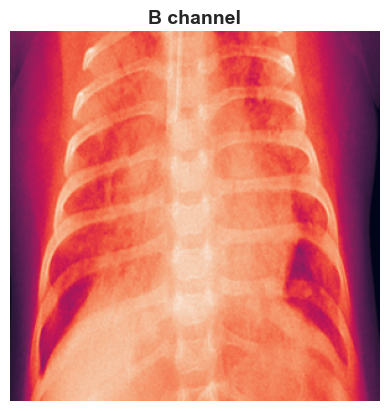

In [12]:
plt.title('B channel',fontsize = 14,weight = 'bold')
plt.imshow(image[ : , : , 0])
plt.axis('off');
plt.show()

Como se mostró hasta ahora, las imágenes no son más que una serie de números en un formato [Alto, Ancho, Canal]. Con eso en mente, procedemos con nuestra EDA.

Aquí comenzamos a examinar si existe algún patrón entre los valores de color de la imagen y su clase. Un gráfico de distribución ilustra cómo se presentan los valores de color medios, máximos y mínimos para el conjunto de datos.

In [13]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(0,samples):
    mean_val.append(data['image'][i].mean())
    std_dev_val.append(np.std(data['image'][i]))
    max_val.append(data['image'][i].max())
    min_val.append(data['image'][i].min())

imageEDA = data.loc[:,['image', 'Class','path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

subt_mean_samples = imageEDA['mean'].mean() - imageEDA['mean']
imageEDA['subt_mean'] = subt_mean_samples

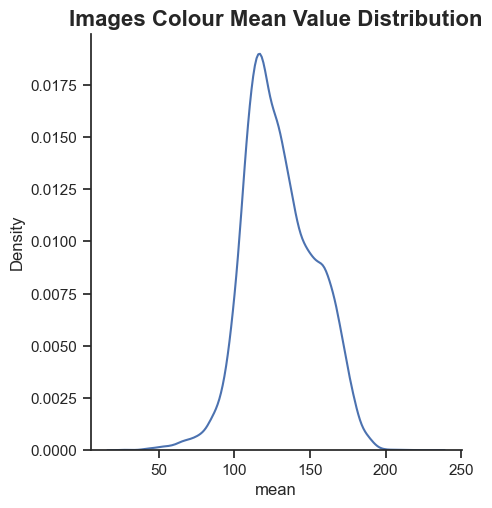

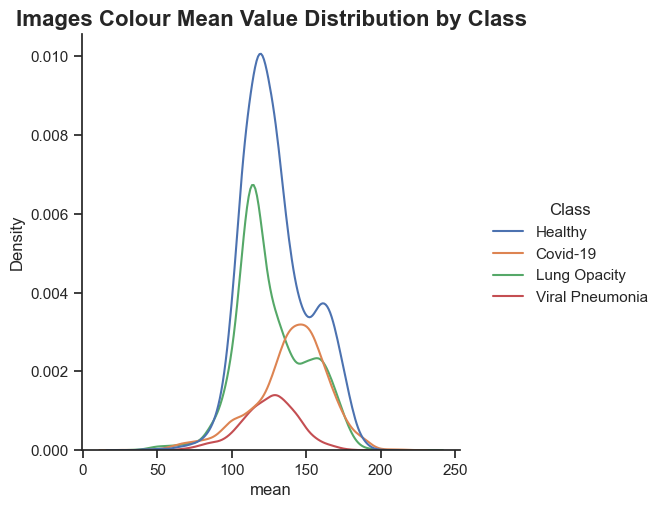

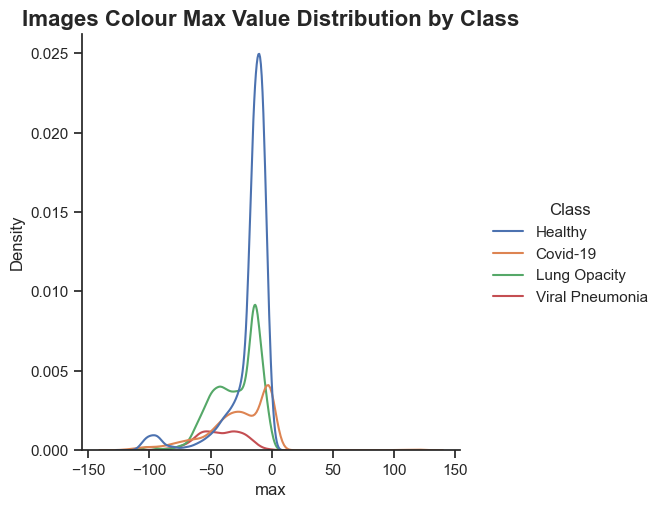

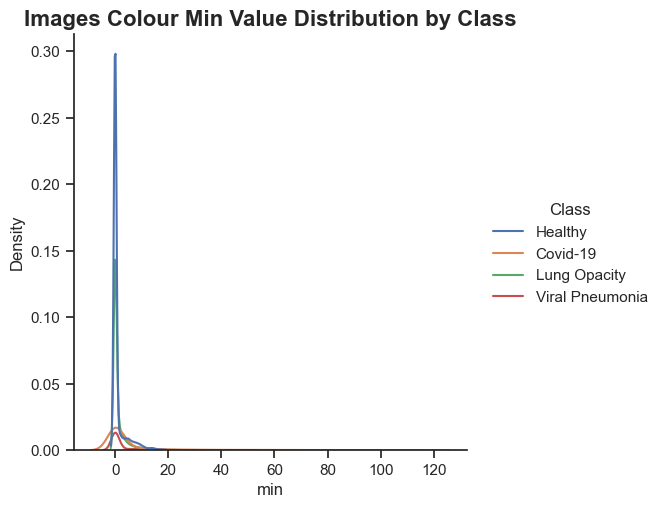

In [14]:
ax = sns.displot(data = imageEDA, x = 'mean', kind="kde");
plt.title('Images Colour Mean Value Distribution', fontsize = 16,weight = 'bold');
ax = sns.displot(data = imageEDA, x = 'mean', kind="kde", hue = 'Class');
plt.title('Images Colour Mean Value Distribution by Class', fontsize = 16,weight = 'bold');
ax = sns.displot(data = imageEDA, x = 'max', kind="kde", hue = 'Class');
plt.title('Images Colour Max Value Distribution by Class', fontsize = 16,weight = 'bold');
ax = sns.displot(data = imageEDA, x = 'min', kind="kde", hue = 'Class');
plt.title('Images Colour Min Value Distribution by Class', fontsize = 16,weight = 'bold');

## Disperción por clase

<Figure size 2000x800 with 0 Axes>

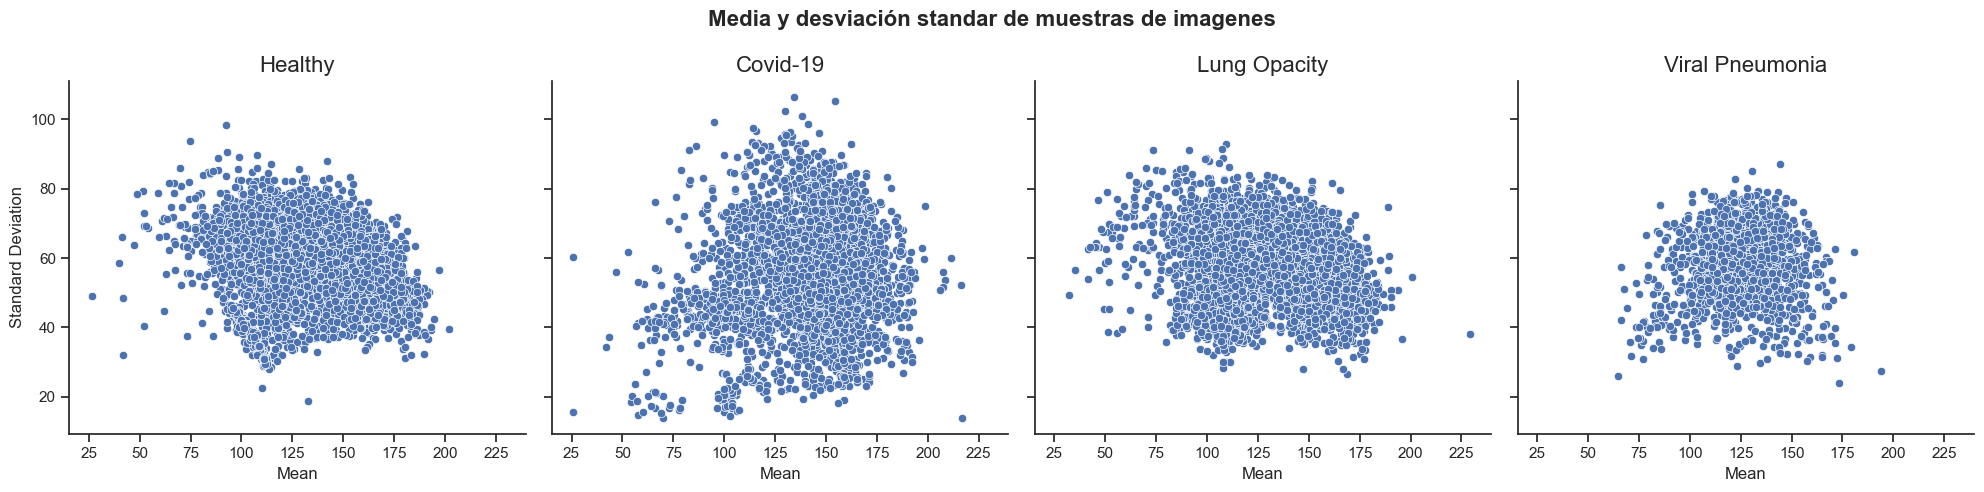

In [15]:
plt.figure(figsize=(20,8));
g = sns.FacetGrid(imageEDA, col="Class",height=5);
g.map_dataframe(sns.scatterplot, x='mean', y='stedev');
g.set_titles(col_template="{col_name}", row_template="{row_name}", size = 16)
g.fig.subplots_adjust(top=.7)
g.fig.suptitle('Media y desviación standar de muestras de imagenes',fontsize=16, weight = 'bold')
axes = g.axes.flatten()
axes[0].set_ylabel('Standard Deviation');
for ax in axes:
    ax.set_xlabel('Mean')
g.fig.tight_layout()

In [ ]:
## separar imagenes por clase 

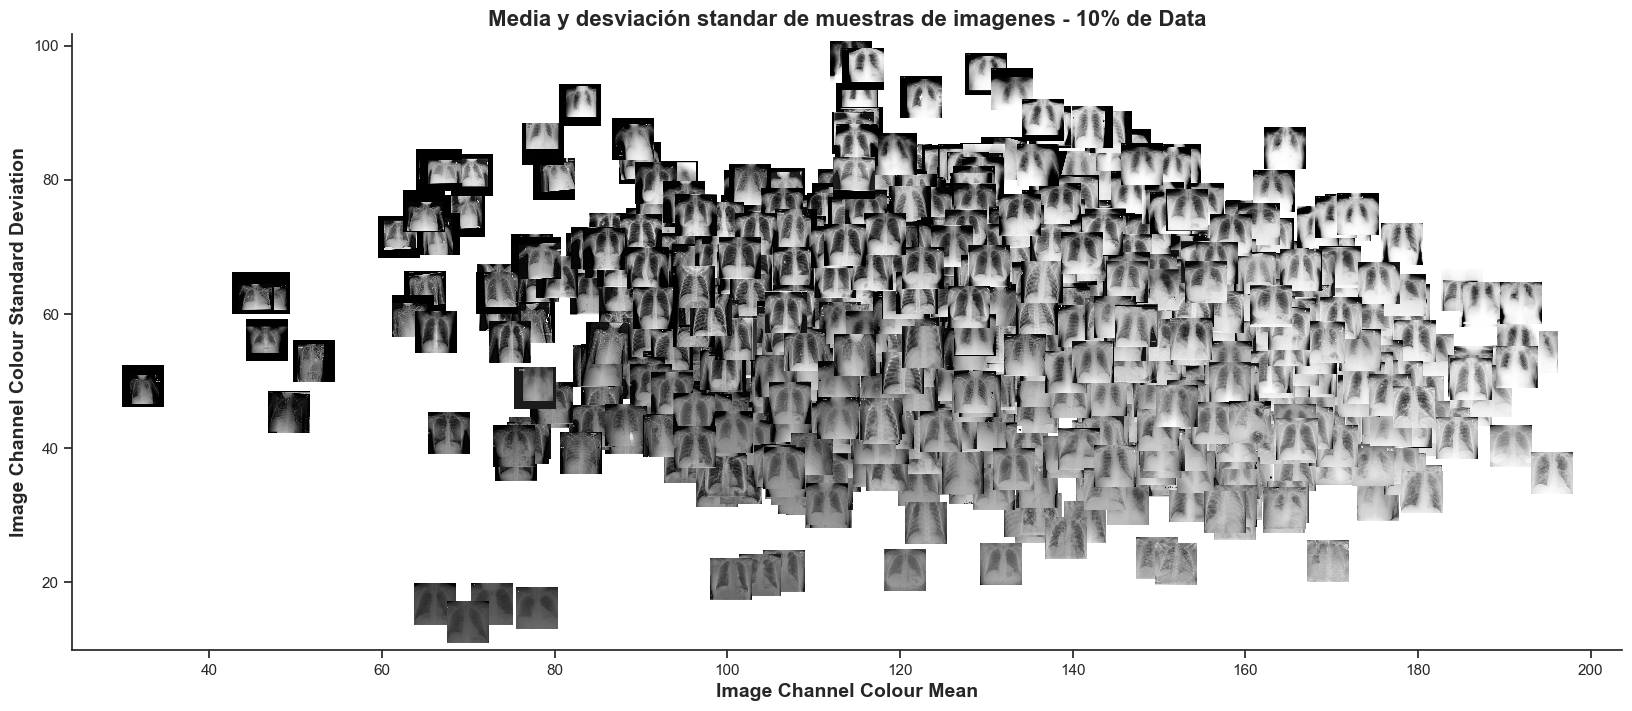

In [16]:
def getImage(path):
    return OffsetImage(cv2.imread(path),zoom = 0.1)

DF_sample = imageEDA.sample(frac=0.1, replace=False, random_state=1)
paths = DF_sample['path']

fig, ax = plt.subplots(figsize=(20,8))
ab = sns.scatterplot(data=DF_sample, x="mean", y='stedev')
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('Image Channel Colour Mean',fontsize = 14,weight = 'bold')
ax.set_ylabel('Image Channel Colour Standard Deviation',fontsize = 14,weight = 'bold')
plt.title('Media y desviación standar de muestras de imagenes - 10% de Data', fontsize = 16,weight = 'bold');

for x0, y0, path in zip(DF_sample['mean'], DF_sample['stedev'],paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)

### TRASFORMACION 

In [ ]:
## NORMALIZACION
## RECORTE
## CAMBIAR A B-CANAL

In [17]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Reading 

import os
from glob import glob
from PIL import Image

# Data Processing 

import numpy as np
import pandas as pd
import cv2
import random
import albumentations as A

# Data Analysis

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Data Modeling & Model Evaluation

from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

# Grad-CAM

import keras
import matplotlib.cm as cm

In [18]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.show()

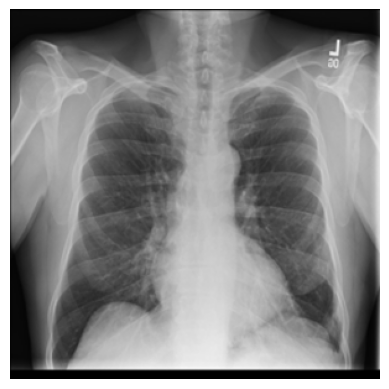

In [368]:
plt.figure()
pic_id = random.randrange(0, samples)
picture = data['path'][pic_id]
chosen_image = cv2.imread(picture)
plt.imshow(chosen_image)
plt.axis('off');
plt.show()      

In [369]:
import numpy as np
import pydicom
import cv2
import matplotlib.pyplot as plt
from skimage.transform import resize

In [373]:
img = cv2.imread(picture)

In [374]:
# Obtener las dimensiones originales de la imagen
height, width = img.shape[:2]

# Redimensionar la imagen
new_width = int(width * 0.5)
new_height = int(height * 0.5)
resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

# Escalar los píxeles
#rescaled_img = cv2.normalize(resized_img, None, 0, 255, cv2.NORM_MINMAX)

# Convertir la imagen a formato uint8
final_img = resized_img.astype(np.uint8)

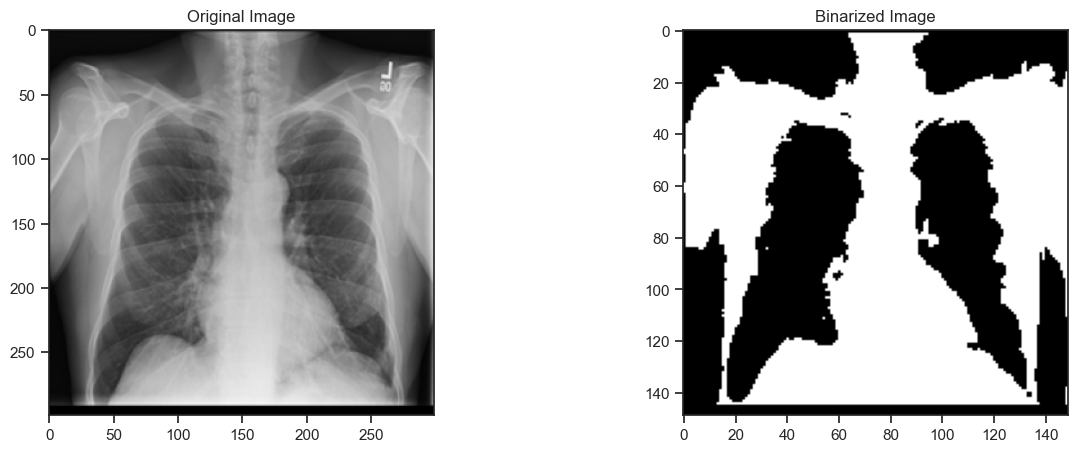

In [375]:
# Binarizar la imagen
thresh = 120
img_bin = cv2.threshold(final_img, thresh, 255, cv2.THRESH_BINARY)[1]

# Mostrar las imágenes
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title('Binarized Image')
plt.imshow(img_bin, cmap='gray')

plt.show()

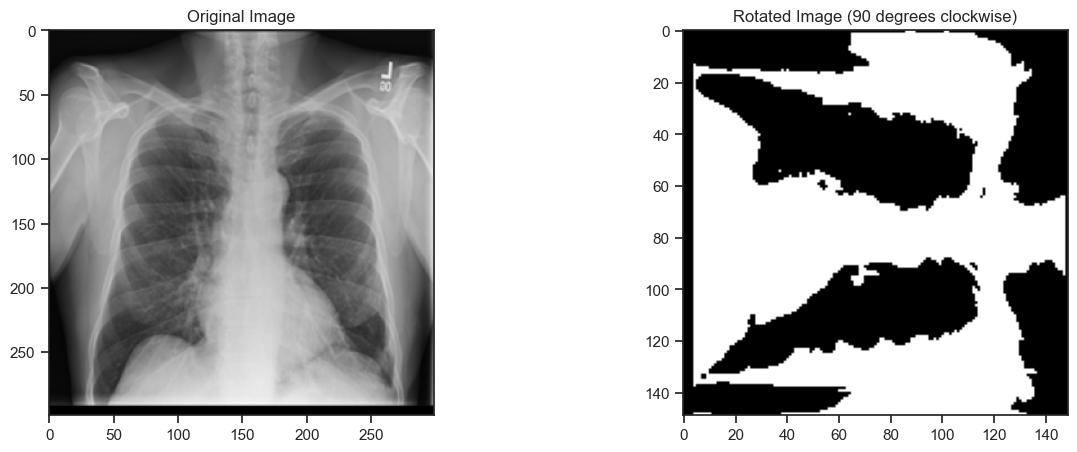

In [376]:
import cv2
import matplotlib.pyplot as plt

# Rotar la imagen 90 grados en sentido horario
img_bin = cv2.rotate(img_bin, cv2.ROTATE_90_CLOCKWISE)

# Mostrar la imagen original y la imagen rotada
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title('Rotated Image (90 degrees clockwise)')
plt.imshow(cv2.cvtColor(img_bin, cv2.COLOR_BGR2RGB))

plt.show()

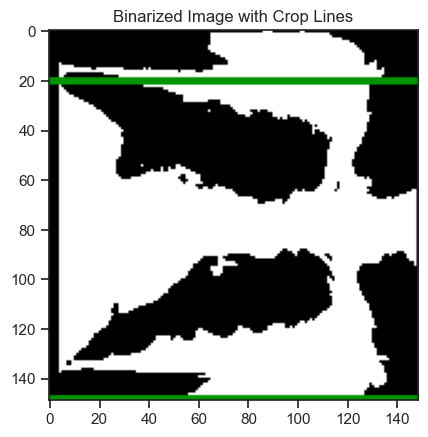

In [377]:
# Establecer parámetros para el recorte
right = 0
left = 0
line_thickness = 2
intensity_threshold = 150

# Encontrar el lado derecho de la imagen
for i in range(img_bin.shape[0] - 1, 0, -10):
    row_mean = img_bin[i].mean()
    if row_mean > intensity_threshold:
        right = i
        cv2.line(img_bin, (0, i), (img_bin.shape[1], i), (0, img_bin.shape[1], 0), thickness=line_thickness)
        break

# Encontrar el lado izquierdo de la imagen
for i in range(0, img_bin.shape[0] - 1, 10):
    row_mean = img_bin[i].mean()
    if row_mean > intensity_threshold:
        left = i
        cv2.line(img_bin, (0, i), (img_bin.shape[1], i), (0, img_bin.shape[1], 0), thickness=line_thickness)
        break

# Mostrar la imagen con las líneas de recorte
plt.imshow(img_bin, cmap='gray')
plt.title('Binarized Image with Crop Lines')
plt.show()


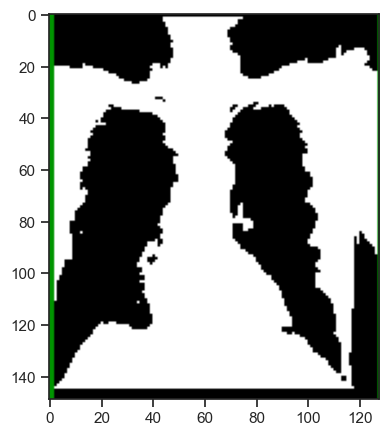

In [378]:
# Rotate the image back to it's normal orientation
img_bin = cv2.rotate(img_bin, cv2.ROTATE_90_COUNTERCLOCKWISE)

x1 = left
y1 = 0
x2 = right
y2 = img_bin.shape[1]

# Grab the region we identified from the binarized image
img_cropped = img_bin[y1:y2, x1:x2]
plt.figure(figsize=(15,5))
plt.imshow(img_cropped,cmap="gray");

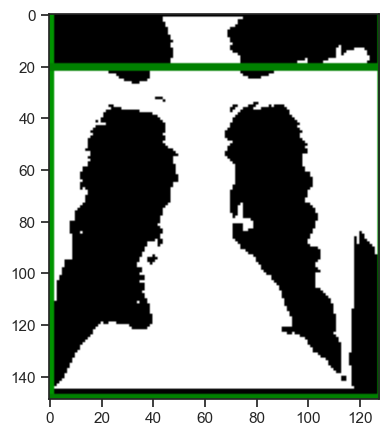

In [379]:
top = 0;
bottom = 0;

# Set some threshold values to specify what we consider edge vs patient
bright_threshold = 150
dark_threshold = 150

# Start at the bottom and work upward
for i in range(img_cropped.shape[0]-1,0,-10):
    row_mean = img_cropped[i].mean()
    if row_mean < bright_threshold:
        # Add 100 pixels of padding so we don't cut the costophrenic angles off
        bottom = i 
        cv2.line(img_cropped, (0, bottom), (img_cropped.shape[1], bottom), (0, img_cropped.shape[1], 0), thickness=line_thickness)
        break

        
# Start at the top and go down
for i in range(0,img_cropped.shape[0]-1,10):
    row_mean = img_cropped[i].mean()
    if row_mean > dark_threshold:
        top = i +10
        cv2.line(img_cropped, (0, i), (img_cropped.shape[1], i), (0, img_cropped.shape[1], 0), thickness=line_thickness)
        break
        
plt.figure(figsize=(15,5))
plt.imshow(img_cropped,cmap="gray");


In [288]:
top

90

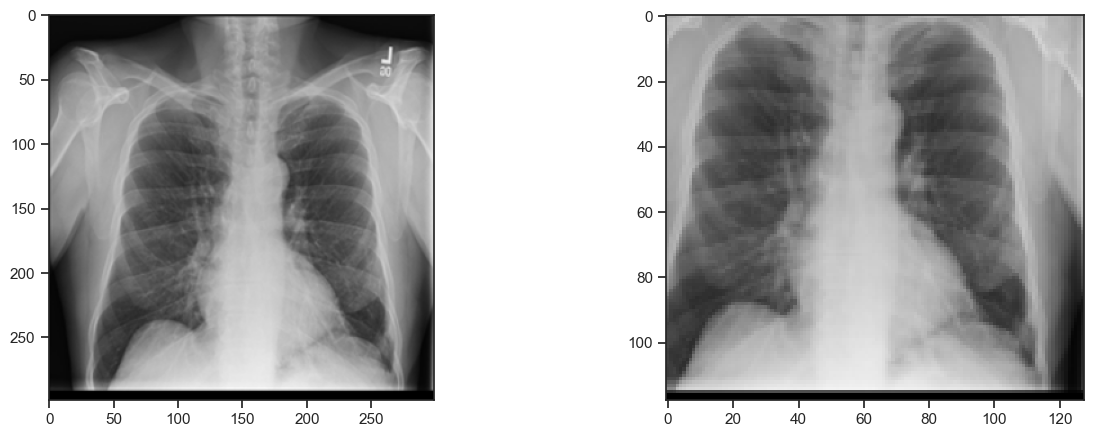

In [380]:
# Display the original image and the cropped section
img_cropped = resized_img[top:bottom, left:right]
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.imshow(img,cmap="gray");

plt.subplot(1, 2, 2)
plt.imshow(img_cropped,cmap="gray");